In [154]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.utils import Sequence

In [155]:
# Importing the scans from processed_scans folder, 
fileNames = []

# Create an array of all the file names from the processed_scans folder
for root, dirs, files in os.walk('processed_scans'):
	for file in files:
		fileNames.append(file)

# Importing the labels from the csv file
labels = pd.read_csv('oasis_cross-sectional.csv', dtype=str)

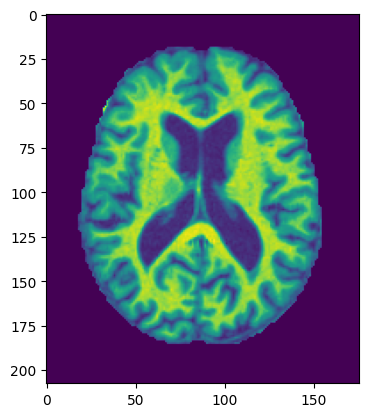

OAS1_0001_MR1.gif
              ID M/F Hand Age Educ SES MMSE CDR  eTIV   nWBV    ASF Delay
0  OAS1_0001_MR1   F    R  74    2   3   29   0  1344  0.743  1.306   NaN


In [156]:
# Display the first image and the label for it
plt.imshow(plt.imread('processed_scans/'+fileNames[0]))
plt.show()
print(fileNames[0])
print(labels[0:1])


In [157]:
image_data = []

for fileName in fileNames:
    img = load_img('processed_scans/'+fileName, target_size=(224, 224, 3))
    img_array = img_to_array(img)
    image_data.append(img_array)

image_data = np.array(image_data)


In [158]:
# Checking to see if there's a corresponding label for each image
checkedLabels = labels[labels['ID'].isin([fileName[:13] for fileName in fileNames])]



In [168]:
directory='C:/Active-Projects/RHUL-FYP/PROJECT/OASIS/processed_scans/'

def createFileName(id):
	return directory + id + ".png"

# Create a new column in the labels dataframe that contains the file name
checkedLabels['fileNames'] = checkedLabels['ID'].apply(createFileName)

# CDR can be '0.0', '0.5', 'nan', '1.0', '2.0'
# As this is not a scale, but more of a classification, this can be passed as a string, then tokenized
def convertToString(cdr):
	if str(cdr) == 'nan':
		return '0'
	else:
		return str(cdr)

# Convert the CDR column to a float (if it's nan, it will be converted to 0)
checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)

# Creating Age_scaled column
checkedLabels['Age_scaled'] = checkedLabels['Age'].apply(lambda x: float(x) / float(checkedLabels['Age'].max()))

# Creating MMSE_scaled column

def mmseConvert(x):
	if math.isnan(float(x)):
		return np.random.randint(25, 30)
	else:
		return x

checkedLabels['MMSE'] = checkedLabels['MMSE'].apply(mmseConvert)



C:\Users\mlg\AppData\Local\Temp\ipykernel_5800\2951820302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['fileNames'] = checkedLabels['ID'].apply(createFileName)
C:\Users\mlg\AppData\Local\Temp\ipykernel_5800\2951820302.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)
C:\Users\mlg\AppData\Local\Temp\ipykernel_5800\2951820302.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [169]:
# Print all the unique values in the CDR column
print(checkedLabels['CDR'].unique())
print(checkedLabels['MMSE'].unique())
print(checkedLabels[[ 'M/F', 'Age', 'Educ', 'MMSE']].isna().sum())

['0' '0.5' '1' '2']
['29' '27' 29 26 28 '30' 25 '28' 27 '23' '26' '22' '21' '15' '25' '18'
 '24' '20' '16' '17' '19' '14']
M/F       0
Age       0
Educ    201
MMSE      0
dtype: int64


In [170]:
train_datagen = ImageDataGenerator(rescale=1/255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    height_shift_range=0.05,
    width_shift_range=0.05,
    shear_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    vertical_flip=False,
)


In [171]:
args = dict(
	dataframe=checkedLabels,
	directory='C:\Active-Projects\RHUL-FYP\PROJECT\OASIS\processed_scans',  # This is required to have the full path for some reason
	x_col='fileNames',
	y_col='CDR',
	target_size=(224, 224),
	batch_size=32,
	class_mode='categorical',# Binary = it outputs 1 number, not the probability of each class
	shuffle=True,
	seed=420,
)

train_ds_tmp = train_datagen.flow_from_dataframe(
	**args,
	subset='training',
)

val_ds_tmp = train_datagen.flow_from_dataframe(
	**args,
	subset='validation',
)

Found 348 validated image filenames belonging to 4 classes.
Found 87 validated image filenames belonging to 4 classes.


In [172]:
# TODO: implement the normalizer

# Import sk learn normalizer
from sklearn.preprocessing import Normalizer

# Create a normalizer
normalizer = Normalizer()

# Fit the normalizer to the training data
normalizer.fit([checkedLabels['Age'], checkedLabels['MMSE']])

Normalizer()

In [173]:
# https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3 For help
class CustomGenerator(Sequence):
	def __init__(self, df, datagen, batch_size, target_size):
		self.df = df
		self.datagen = datagen
		self.batch_size = batch_size
		self.target_size = target_size
			
	def __len__(self):
		return int(np.ceil(len(self.df) / self.batch_size))
	
	def on_epoch_end(self):
		pass
	
	def __getitem__(self, idx):

		# If the batch size is not a multiple of the total number of images, the last batch will be smaller
		batchEnd = (idx+1)*self.batch_size if (idx+1)*self.batch_size < len(self.df) else len(self.df)

		#print(f"batch: {idx*self.batch_size} {batchEnd}, idx: {idx}")

		# Get the batch
		batch = self.df[idx*self.batch_size:batchEnd]

		# Create the arrays to store the images and labels
		batch_x = np.zeros((len(batch),) + self.target_size + (3,), dtype='float32')
		batch_y = np.zeros((len(batch),), dtype='int32')

		# Create the arrays to store the attributes
		batch_a = np.zeros((len(batch), 3), dtype='float32')
		
		for i, row in batch.iterrows():
			try:
				# i refers to the index of the dataframe, not the batch
				currentIndex = i % self.batch_size - 1

				#print(f"i: {i}, currentIndex: {currentIndex}, batchEnd: {batchEnd}, batchStart: {idx*self.batch_size}")

				img = tf.keras.preprocessing.image.load_img(
					row['fileNames'],
					target_size=self.target_size
				)
				x = tf.keras.preprocessing.image.img_to_array(img)
				x = self.datagen.random_transform(x)
				x = self.datagen.standardize(x)

				batch_x[currentIndex] = x

				batch_y[currentIndex] = float(row['CDR'])
				batch_a[currentIndex, 0] = float(1 if row['M/F'] == 'M' else 0)
				batch_a[currentIndex, 1] = float(row['Age'])
				batch_a[currentIndex, 2] = float(row['MMSE'])
			except Exception as e:
				print(f";( {e}")
			
		return ([batch_a, batch_x], batch_y)

	

In [174]:
# Setting the train/validation split
split = 0.8
splitIndex = int(len(checkedLabels) * split)

train_ds = CustomGenerator(
    checkedLabels[:splitIndex],
    train_datagen,
    batch_size=8,
    target_size=(224, 224)
)

val_ds = CustomGenerator(
    checkedLabels[splitIndex:],
    train_datagen,
    batch_size=8,
    target_size=(224, 224)
)

M/F (0 = F, 1 = M): 0.0, Age:55.0, MMSE Score:29.0
CDR: 0


c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


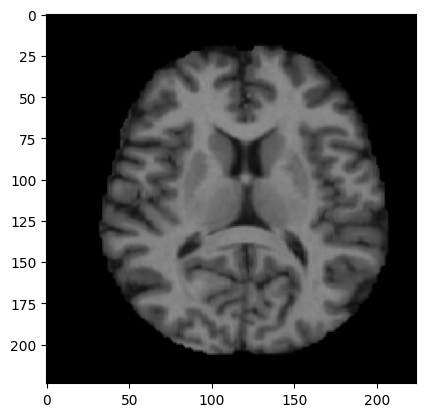

In [175]:
# Getting a batch from the generator
sample = train_ds.__getitem__(0)

# Selecting the first image from the batch
img = sample[0][1][0]

# getting the image attributes
attributes = sample[0][0][0]
print(f"M/F (0 = F, 1 = M): {attributes[0]}, Age:{attributes[1]}, MMSE Score:{attributes[2]}")

# getting the CDR value
print(f"CDR: {sample[1][0]}")

# Plotting the image
plt.imshow(img)


In [176]:
# Creating a sub-model to be concatenated with the main model, with age/gender/education/MMSE as input

sub_model_input = Input(shape=(3,))

x = Dense(64, activation='relu')(sub_model_input)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

sub_model_output = Dense(64, activation='relu')(x)

sub_model = Model(inputs=sub_model_input, outputs=sub_model_output)


In [177]:
# Here I'm using the MobileNetV2 model for testing purposes as it is a lightweight model
preTrainedModel = keras.applications.InceptionV3(
	input_shape=(224, 224, 3),
	include_top=False,
)

for _ in range(5):
	preTrainedModel.layers.pop()

# Freezing the layers of the model so that they don't get trained (apart from the last 10)
# This should help the training to not override the feature extraction layers
for layer in preTrainedModel.layers[:-5]:
	layer.trainable = False

In [178]:


inputs = Input(shape=(224, 224, 3))
x = preTrainedModel(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Concatenate()([sub_model.output, x])
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=[sub_model_input, inputs], outputs=outputs)

# The summary of the model is shown, this is to check if the model is being built correctly
model.summary()

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.00001),
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense_30 (Dense)               (None, 64)           256         ['input_19[0][0]']               
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['input_21[0][0]']        

Epoch 1/80
44/44 [==============================] - 9s 113ms/step - loss: 0.9239 - accuracy: 0.6695 - val_loss: 0.3524 - val_accuracy: 0.9195
Epoch 2/80
44/44 [==============================] - 4s 77ms/step - loss: 0.3356 - accuracy: 0.9282 - val_loss: 0.2810 - val_accuracy: 0.9195
Epoch 3/80
44/44 [==============================] - 3s 77ms/step - loss: 0.3236 - accuracy: 0.9195 - val_loss: 0.2448 - val_accuracy: 0.9195
Epoch 4/80
44/44 [==============================] - 3s 77ms/step - loss: 0.3305 - accuracy: 0.9109 - val_loss: 0.2269 - val_accuracy: 0.9195
Epoch 5/80
44/44 [==============================] - 4s 79ms/step - loss: 0.2598 - accuracy: 0.9282 - val_loss: 0.2971 - val_accuracy: 0.9195
Epoch 6/80
44/44 [==============================] - 4s 94ms/step - loss: 0.2679 - accuracy: 0.9310 - val_loss: 0.2218 - val_accuracy: 0.9195
Epoch 7/80
44/44 [==============================] - 3s 77ms/step - loss: 0.2678 - accuracy: 0.9282 - val_loss: 0.2383 - val_accuracy: 0.9195
Epoch 8/80
4

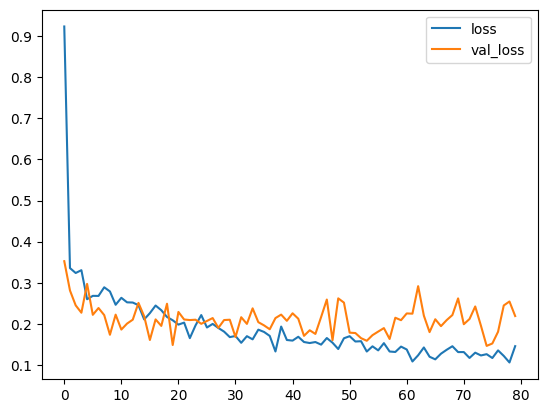

In [179]:
# Fit the model to the training data
history = model.fit(
	x=train_ds,
	epochs=80,
	validation_data=val_ds,
	batch_size=8,
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [180]:
# Unfreeze all the layers of the model
for layer in preTrainedModel.layers:
	layer.trainable = True

# Compile the model again, with a slower learning rate

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.000001),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

# Fit the model to the training data
history = model.fit(
	train_ds,
	epochs=80,
	validation_data=val_ds,
)

Epoch 1/80


ValueError: in user code:

    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


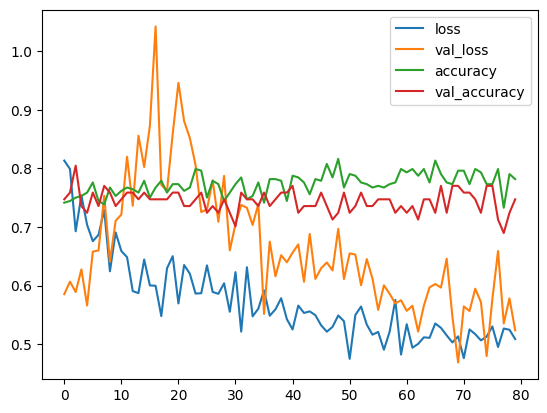

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(val_ds)

3/3 [==============================] - 12s 6s/step


In [ ]:
# Compare the predictions to the true labels (in val_ds) and print the results
print('Accuracy: ', np.sum(predictions.argmax(axis=1) == val_ds.classes) / len(val_ds.classes))

Accuracy:  0.6666666666666666


In [ ]:
predictionAccuracy = [[], [], [], []]

predictionsList = predictions.tolist()

# predictions lambda
for i in range(len(predictions)):#
  # Get the highest probability in the given prediction, rounding due to floating point errors
  highestProbability = [round(pred, 5) for pred in predictionsList[i]].index(round(max(predictionsList[i]), 5))

  # Check if the highest probability is the same as the true label
  truePrediction = highestProbability == val_ds.classes[i]

  # Append the result to the dictionary
  predictionAccuracy[val_ds.classes[i]].append(truePrediction)

# Print the accuracy of each class]

for pred in predictionAccuracy:
  # Get the number of correct predictions
  correctPredictions = pred.count(True)
  # Get the number of incorrect predictions
  incorrectPredictions = pred.count(False)

  # Print the accuracy of the class
  print(f"Class: {predictionAccuracy.index(pred)} Correct: {correctPredictions} Incorrect: {incorrectPredictions}")


Class: 0 Correct: 57 Incorrect: 8
Class: 1 Correct: 1 Incorrect: 13
Class: 2 Correct: 0 Incorrect: 8
Class: 3 Correct: 0 Incorrect: 0
